# Laboratory 4: Getting started with Pytorch

In this laboratory we will begin working with Pytorch to implement and train complex, nonlinear models for supervised learning problems. You will notice many similarities between Numpy and Pytorch -- this is deliberate, but it can cause some confusion and for many things we will have to convert back and forth between Numpy arrays and Pytorch tensors.

## Part 0: First steps

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [1]:
# We're still going to need numpy and matplotlib.
import numpy as np
import matplotlib.pyplot as plt

# Verify that pytorch is working.
import torch

foo = torch.randn((3, 3))
print(foo)

tensor([[ 0.2409, -1.4870, -1.2155],
        [ 0.7053, -1.0204, -0.8292],
        [-2.8746, -0.1819,  2.4347]])


## Part 1: Dataset preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use.

In [ ]:
# Download and load the MNIST dataset.
from torchvision.datasets import MNIST
import torchvision

# Load the MNIST training and test splits.
ds_train = MNIST(root='./data', download=True, train=True)
ds_test  = MNIST(root='./data', download=True, train=False)

### Exercise 1.1: Exploratory data analysis

Spend some time inspecting the `ds_train` and `ds_test` data structures in order to get a feel for the data. What is the format? How big are the images? How many are there? What about the range of pixel values? Where are the labels for images?

Remember that one of the best ways to explore is to *visualize*.

In [3]:
print(f"# of images in training set: {len(ds_train)}")
print(f"# of images in test set: {len(ds_test)}")

# of images in training set: 60000
# of images in test set: 10000


In [4]:
image, label = ds_train[0]
print(f"Image dimension: {image.size}")
print(f"Range of pixel values: {image.getextrema()}")  

Image dimension: (28, 28)
Range of pixel values: (0, 255)


In [5]:
print(f"Label of the first image in the training set: {label}")

Label of the first image in the training set: 5


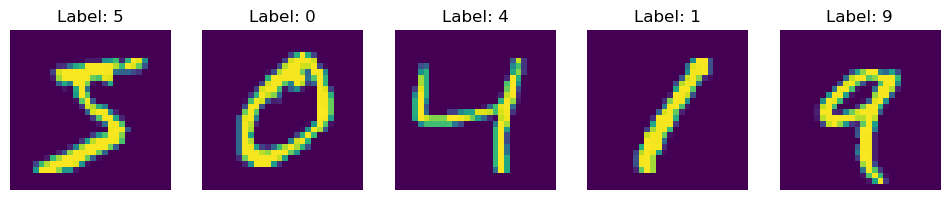

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(12, 5))
for i in range(5):
    image, label = ds_train[i]
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()

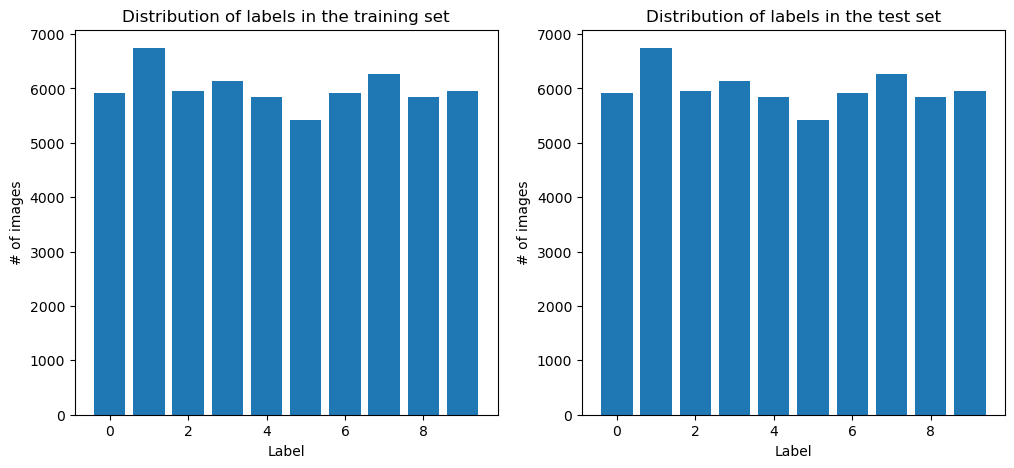

In [7]:
from collections import Counter

count = Counter([label for _, label in ds_train])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(count.keys(), count.values())
ax[0].set_title('Distribution of labels in the training set')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('# of images')

ax[1].bar(count.keys(), count.values())
ax[1].set_title('Distribution of labels in the test set')
ax[1].set_xlabel('Label')
ax[1].set_ylabel('# of images')

plt.show()

### Exercise 1.2: Dataset conversion and normalization

+ **Datatype Conversion**:
The first thing we need to do is convert all data tensors to `torch.float32` -- this is fundamental as it is extremely inconvenient to work with `uint8` data. Using 32-bit floating point numbers is a compromise between precision and space efficiency.
The `torch.Tensor` class has a very useful method `to()` for performing datatype and device (e.g. to GPU) conversions. Check out the [documentation here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to).

+ **Normalization**:
Next, we need to correct the inconvenient range of [0, 255] for the pixel values. You should *subtract* the mean intensity value and divide by the standard deviation in order to *standardize* our data. **Important**: Think *very carefully* about *which* split you should use to compute the pixel statistics for standardization.

+ **Reshaping**: Is the data in an appropriate format (i.e. shape) for the training the models we know? Think about whether (and how) to fix this if needed. 

**What to do**: In the cell below you should perform this sequence preprocessing operations on the `ds_train.data` and `ds_test.data` tensors. 

In [8]:
# datatype conversion
ds_train.data = ds_train.data.to(torch.float32)
ds_test.data = ds_test.data.to(torch.float32)

# normalization
mean = ds_train.data.mean().item()
std = ds_train.data.std().item()
ds_train.data = (ds_train.data - mean) / std
ds_test.data = (ds_test.data - mean) / std

# reshaping
print(f"Shape of training data before reshaping: {ds_train.data.shape}")
print(f"Shape of test data before reshaping: {ds_test.data.shape}")

ds_train.data = ds_train.data.unsqueeze(1)  
ds_test.data = ds_test.data.unsqueeze(1)    

print(f"\nShape of training data after reshaping: {ds_train.data.shape}")
print(f"Shape of test data after reshaping: {ds_test.data.shape}")
print(f"Type of training data: {ds_train.data.dtype}")
print(f"Type of training data: {ds_test.data.dtype}")

Shape of training data before reshaping: torch.Size([60000, 28, 28])
Shape of test data before reshaping: torch.Size([10000, 28, 28])

Shape of training data after reshaping: torch.Size([60000, 1, 28, 28])
Shape of test data after reshaping: torch.Size([10000, 1, 28, 28])
Type of training data: torch.float32
Type of training data: torch.float32


I dati erano inizialmente della forma (N, 28, 28) ma per un modello di deep learning abbiamo bisogno di dati nella forma (N, 1, 28, 28). Abbiamo quindi aggiunto una dimensione.

### Exercise 1.3: Subsampling the MNIST dataset.

MNIST is kind of big, and thus inconvenient to work with unless using the GPU. For this laboratory we will use a smaller subset of the dataset for training to keep memory and computation times low.

Modify `ds.train` to use only a subset of, say, 10000 images sampled from the original data. Make sure to select the correct corresponding targets.


In [9]:
from torch.utils.data import Subset

indices = torch.randperm(len(ds_train))[:10000]

ds_train.data = ds_train.data[indices]
ds_train.targets = ds_train.targets[indices]

print(f"\nShape of training data (subset): {ds_train.data.shape}")
print(f"Shape of test data (subset): {ds_test.data.shape}")


Shape of training data (subset): torch.Size([10000, 1, 28, 28])
Shape of test data (subset): torch.Size([10000, 1, 28, 28])


## Establishing a stable baseline

In this exercise you will establish a reliable baseline using a classical approach. This is an important step in our methodology in order to judge whether our Deep MLP is performing well or not.

### Exercise 2.1: Establish the stable baseline

Train and test your stable baseline to estimate the best achievable accuracy using classical models.

**Tip**: Don't do any extensive cross-validation of your baseline (for now). Just fit a simple model (e.g. a linear SVM) and record the accuracy.



In [19]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# converto i tensori in array numpy per scikit-learn
X_train = ds_train.data.view(-1, 28*28).numpy()
y_train = ds_train.targets.numpy()
X_test = ds_test.data.view(-1, 28*28).numpy()
y_test = ds_test.targets.numpy()

svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8722


C:\Users\Salvatore Baglieri\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Part 3: Training some deep models (finally)

Now we will finally train some deep models (Multilayer Perceptrons, to be precise). Since the dataset is a bit too large to use batch gradient descent, we will first need to setup a `torch.utils.data.DataLoader` for our training data. A `DataLoader` breaks the dataset up into a sequence of *batches* that will be used for training. In order to use this, we will first have to use `torch.utils.data.TensorDataset` on `ds_train.data` and `ds_train.targets` to make a new torch `dataset` for use in the dataloader. 

### Exercise 3.1: Creating the DataLoader

Create a `DataLoader` for `ds_train` use a `batch_size` of about 16 or 32 to start. After you have your `DataLoader` experiment with is using `next(iter(dl_train))` to see what it returns. The pytorch `DataLoader` is a Python iterator.

**EXTREMELY IMPORTANT**: Make sure you use `shuffle=True` in the constructor of your dataloader.

In [11]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 32

train_dataset = TensorDataset(ds_train.data, ds_train.targets)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(ds_test.data, ds_test.targets)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


images, labels = next(iter(train_loader))
print(f"Batch shape of images: {images.shape}") 
print(f"Batch shape of labels: {labels.shape}") 
print(f"Image data type: {images.dtype}")  
print(f"Label data type: {labels.dtype}") 

Batch shape of images: torch.Size([32, 1, 28, 28])
Batch shape of labels: torch.Size([32])
Image data type: torch.float32
Label data type: torch.int64


### Some support code (NOT an exercise).

Here is some support code that you can use to train a model for a **single** epoch. The function returns the mean loss over all iterations. You will use it in the next exercise to train and monitor training.

In [12]:
# Train a model for a single epoch. You should pass it a model, a dataloader,
# and an optimizer. Returns the mean loss over the entire epoch.
def train_epoch(model, dl, optimizer):
    model.train()
    losses = []
    for (xs, ys) in dl:
        optimizer.zero_grad()
        output = model(xs)
        loss = torch.nn.functional.nll_loss(output, ys)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    model.eval()
    return np.mean(losses)

### Exercise 3.2: Defining a 1-layer neural network

Define a simple model that uses a **single** `torch.nn.Linear` layer followed by a `torch.nn.Softmax` to predict  the output probabilities for the ten classes.

In [13]:
import torch
import torch.nn as nn

model = torch.nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 10), 
    nn.LogSoftmax(dim=1)  
)

print(model)

# uso la logSoftmax perchè nei passi successivi mi ritrovavo con una loss negativa

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): LogSoftmax(dim=1)
)


### Exercise 3.2: Training our model

Instantiate a `torch.optim.SGD` optimizer using `model.parameters()` and the learning rate (**tip**: make the learning rate variable you can easily change). Then run `train_epoch` for a set number of epochs (e.g. 100, make this a variable too). Is your model learning? How can you tell?

In [14]:
import torch.optim as optim

def evaluate(model, dl):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for (xs, ys) in dl:
            output = model(xs)
            loss = torch.nn.functional.nll_loss(output, ys)
            losses.append(loss.item())
            _, predicted = torch.max(output, 1)
            total += ys.size(0)
            correct += (predicted == ys).sum().item()
    accuracy = correct / total
    avg_loss = np.mean(losses)
    return accuracy, avg_loss

learning_rate = 0.001
num_epochs = 100

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_losses = [] # servità al passo successivo
test_losses = []
test_accuracies = []
for epoch in range(num_epochs):
    avg_loss = train_epoch(model, train_loader, optimizer)
    train_losses.append(avg_loss)
    test_accuracy, test_loss = evaluate(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train average loss: {avg_loss:.4f}, Test average loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")



Epoch 1/100, Train average loss: 1.4558, Test average loss: 0.9565, Test accuracy: 0.7972
Epoch 2/100, Train average loss: 0.8238, Test average loss: 0.6964, Test accuracy: 0.8460
Epoch 3/100, Train average loss: 0.6584, Test average loss: 0.5909, Test accuracy: 0.8662
Epoch 4/100, Train average loss: 0.5791, Test average loss: 0.5330, Test accuracy: 0.8739
Epoch 5/100, Train average loss: 0.5305, Test average loss: 0.4955, Test accuracy: 0.8788
Epoch 6/100, Train average loss: 0.4976, Test average loss: 0.4691, Test accuracy: 0.8810
Epoch 7/100, Train average loss: 0.4736, Test average loss: 0.4493, Test accuracy: 0.8849
Epoch 8/100, Train average loss: 0.4550, Test average loss: 0.4337, Test accuracy: 0.8873
Epoch 9/100, Train average loss: 0.4399, Test average loss: 0.4220, Test accuracy: 0.8893
Epoch 10/100, Train average loss: 0.4274, Test average loss: 0.4116, Test accuracy: 0.8905
Epoch 11/100, Train average loss: 0.4167, Test average loss: 0.4027, Test accuracy: 0.8917
Epoch 12

Possiamo vedere che la loss tende a diminuire ad ogni epoca, questo implica che il modello sta imparando e riesce a predirre sempre meglio le etichette

### Exercise 3.3: Evaluating our model

Write some code to plot the loss curve for your training run and evaluate the performance of your model on the test data. Play with the hyperparameters (e.g. learning rate) to try to get the best performance on the test set. Can you beat the stable baseline?

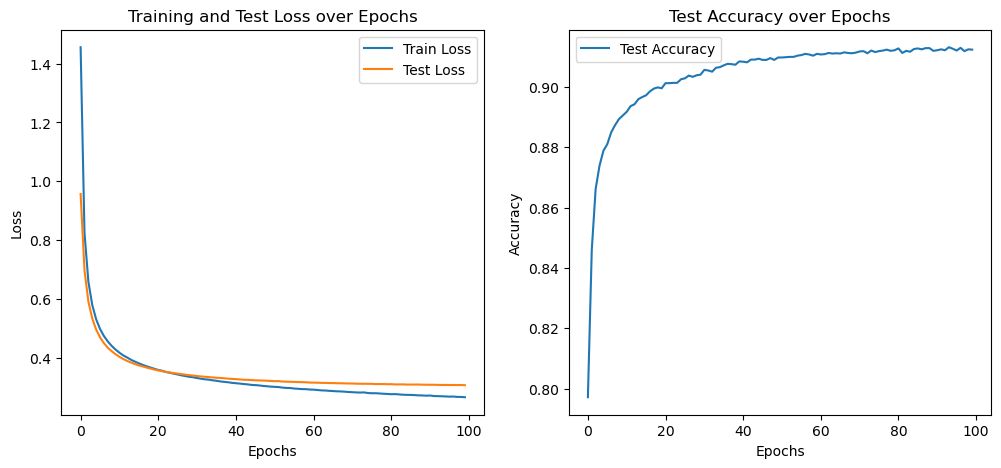

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.show()

## Going Deeper

Now we will go (at least one layer) deeper to see if we can significantly improve on the baseline.

### Exercise 3.4: A 2-layer MLP
Define a new model with one hidden layer. Use the code you wrote above to train and evaluate this new model. Can you beat the baseline? You might need to train in two stages using different learning rates.

**Things to think about**:

+ It might be hard to beat (or even equal) the baseline with deeper networks. Why?
+ Is there something else we should be monitoring while training, especially for deep networks?

In [16]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(28*28, 128)  # Livello nascosto con 128 neuroni
        self.relu = nn.ReLU()
        self.output = nn.Linear(128, 10)  # Strato di output con 10 neuroni
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.log_softmax(x)
        return x

model = SimpleNN()

In [17]:
model = SimpleNN()

learning_rate_phase1 = 0.01
learning_rate_phase2 = 0.001
optimizer = optim.SGD(model.parameters(), lr=learning_rate_phase1)

num_epochs_phase1 = 50
num_epochs_phase2 = 50

train_losses = []
test_losses = []
test_accuracies = []

print('Phase 1\n')
for epoch in range(num_epochs_phase1):
    avg_loss = train_epoch(model, train_loader, optimizer)
    train_losses.append(avg_loss)
    
    test_accuracy, test_loss = evaluate(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs_phase1}, Train average loss: {avg_loss:.4f}, Test average loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")


print('\nPhase 2\n')
optimizer = optim.SGD(model.parameters(), lr=learning_rate_phase2)
for epoch in range(num_epochs_phase2):
    avg_loss = train_epoch(model, train_loader, optimizer)
    train_losses.append(avg_loss)
    
    test_accuracy, test_loss = evaluate(model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch {epoch + 1}/{num_epochs_phase2}, Train average loss: {avg_loss:.4f}, Test average loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")



Phase 1

Epoch 1/50, Train average loss: 0.9461, Test average loss: 0.4738, Test accuracy: 0.8821
Epoch 2/50, Train average loss: 0.4235, Test average loss: 0.3619, Test accuracy: 0.8992
Epoch 3/50, Train average loss: 0.3495, Test average loss: 0.3210, Test accuracy: 0.9103
Epoch 4/50, Train average loss: 0.3122, Test average loss: 0.2991, Test accuracy: 0.9161
Epoch 5/50, Train average loss: 0.2854, Test average loss: 0.2856, Test accuracy: 0.9182
Epoch 6/50, Train average loss: 0.2634, Test average loss: 0.2706, Test accuracy: 0.9231
Epoch 7/50, Train average loss: 0.2445, Test average loss: 0.2618, Test accuracy: 0.9236
Epoch 8/50, Train average loss: 0.2290, Test average loss: 0.2493, Test accuracy: 0.9272
Epoch 9/50, Train average loss: 0.2149, Test average loss: 0.2414, Test accuracy: 0.9296
Epoch 10/50, Train average loss: 0.2015, Test average loss: 0.2293, Test accuracy: 0.9320
Epoch 11/50, Train average loss: 0.1903, Test average loss: 0.2292, Test accuracy: 0.9328
Epoch 12/5

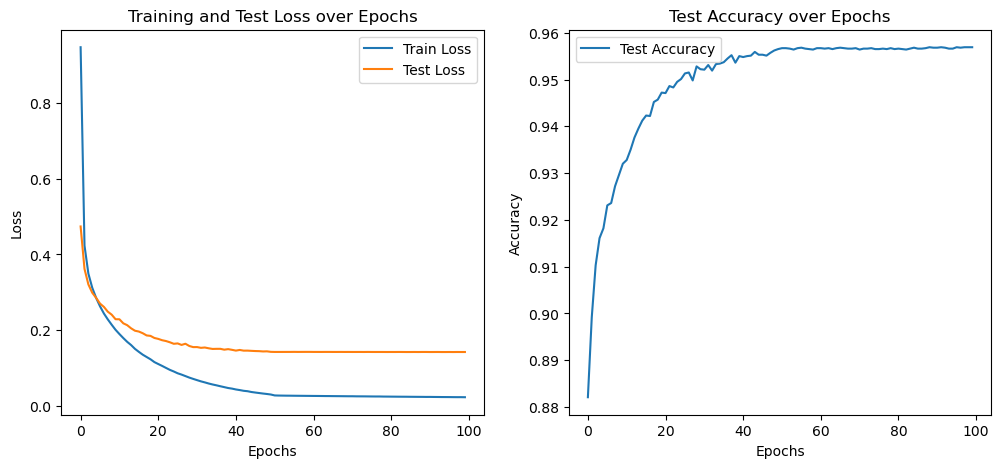

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.show()

I modelli con reti più profonde possono essere difficili da addestrare a causa dei problemi legati ad esempio al vanishing gradient o comunque a causa della maggiore complessità di ottimizzazione rispetto a modelli più semplici. Dovremmo quindi monitorare i gradienti per evitare problemi di vanishing gradient o di esplosione del gradiente, monitorare le attivazioni nei vari strati per identificare problemi di saturazione e osservare l'accuratezza su un set di validazione per rilevare overfitting e implementare tecniche di stopping per interrompere l'addestramento quando le prestazioni non migliorano più.